<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#@title  Packages and Globlal Variables
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import gspread
import random
from scipy.optimize import differential_evolution
#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
#from scipy.interpolate import interp1d


# Precomputed activation energies in kJ/mol (converted to J/mol)
activation_energies = {
    'Asx_ConcTHAA': 111.09 * 1000,
    'Asx_ConcFAA': 98.93 * 1000, 'Asx_DLTHAA': 126.02 * 1000, 'Asx_DLFAA': 121.99 * 1000, 'Glx_ConcTHAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DLTHAA': 121.89 * 1000,
    'Glx_DLFAA': 100.80 * 1000, 'Ser_ConcTHAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DLTHAA': 123.03 * 1000, 'Ser_DLFAA': 116.72 * 1000, 'Ala_ConcTHAA': 96.58 * 1000,
    'Ala_ConcFAA': 112.12 * 1000, 'Ala_DLTHAA': 113.58 * 1000, 'Ala_DLFAA': 98.88 * 1000, 'Val_ConcTHAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000,
    'Val_DLTHAA': 99.73 * 1000, 'Val_DLFAA': 128.52 * 1000, 'Phe_ConcTHAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DLTHAA': 128.15 * 1000, 'Phe_DLFAA': 102.27 * 1000, 'Leu_ConcTHAA': 114.09 * 1000,
    'Leu_ConcFAA': 103.75 * 1000, 'Leu_DLTHAA': 105.43 * 1000, 'Leu_DLFAA': 105.43 * 1000, 'Ile_ConcTHAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DLTHAA': 105.43 * 1000, 'Ile_DLFAA': 105.43 * 1000
}

# Define the mapping from one-letter to three-letter amino acid codes
one_to_three_letter = {
    "I": "Ile", "V": "Val", "L": "Leu", "F": "Phe", "C": "Cys", "M": "Met",
    "A": "Ala", "G": "Gly", "T": "Thr", "W": "Trp", "S": "Ser", "Y": "Tyr",
    "P": "Pro", "H": "His", "Q": "Gln", "E": "Glx", "N": "Asn", "D": "Asx",
    "K": "Lys", "R": "Arg", "D": "Asx", "E": "Glx"
}

# Pre-exponential factors for each type of rate (example values)
pre_exponential_factors = {
    'Asx': {'internal': 1e19, 'terminal': 1e20, 'free': 1e18, 'loss': 1e18},
    'Glx': {'internal': 1e17, 'terminal': 1e20, 'free': 1e17, 'loss': 1e16},
    'Ser': {'internal': 1e19, 'terminal': 1e20, 'free': 1e20, 'loss': 1e15},
    'Ala': {'internal': 1e17, 'terminal': 1e17, 'free': 1e16, 'loss': 1e20},
    'Val': {'internal': 1e17, 'terminal': 1e20, 'free': 1e15, 'loss': 1e10},
    'Phe': {'internal': 1e17, 'terminal': 1e17, 'free': 1e20, 'loss': 1e15},
    'Leu': {'internal': 1e19, 'terminal': 1e18, 'free': 1e13, 'loss': 1e20},
    'Ile': {'internal': 1e16, 'terminal': 1e20, 'free': 1e18, 'loss': 1e20}
}

# Define a mapping from rate type descriptions to pre-exponential factor keys
rate_type_mapping = {
    'ConcTHAA': 'internal',
    'ConcFAA': 'terminal',
    'DLTHAA': 'free',
    'DLFAA': 'loss'
}

# Function to calculate the rate constant using the Arrhenius equation with pre-exponential
# Universal gas constant in J/(mol·K)
R = 8.314
def arrhenius_rate_constant(E_a, T, A):
    return A * np.exp(-E_a / (R * T))


In [2]:
#@title Colours
# Load color dictionary
color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
with open(color_dict_path, 'r') as file:
    color_dict = json.load(file)


# Amino acid colors
amino_acid_colors = color_dict["amino_acids_colors"]
one_to_three_letter = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}
amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}

# Function to adjust color saturation
def adjust_saturation(color, amount=0.5):
    color = mcolors.to_rgba(color)
    color = mcolors.rgb_to_hsv(color[:3])
    color[1] = max(0, min(1, color[1] * amount))
    return mcolors.hsv_to_rgb(color)

# Adjust colors for standard deviations
std_colors = {k: adjust_saturation(v, 0.5) for k, v in amino_acid_colors_three_letter.items()}


In [3]:
def solve_dl(ratio, sum_value):
    """Calculate D and L concentrations given a D/L ratio and their sum."""
    L = sum_value / (1 + ratio)
    D = ratio * L
    return D, L

def update_dl_ratio(D, L, rate, slow_pool_size, slow_pool_relative_rate):
    """Update the D and L values based on decay rate and pool dynamics."""
    fast_pool_size = 1 - slow_pool_size
    rate_fast = rate
    rate_slow = rate * slow_pool_relative_rate
    effective_rate = rate_fast * fast_pool_size + rate_slow * slow_pool_size
    D_new = D + (L * effective_rate) - (D * effective_rate)
    L_new = L - (L * effective_rate) + (D * effective_rate)
    return D_new, L_new


In [4]:
#@title Load Data
# URLs and GIDs for Google Sheets
sheet_id = "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E"
gid = "1259514505"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
try:
  df = pd.read_csv(export_url)
  print("Data successfully loaded into DataFrame!")
except Exception as e:
  print(f"Error: Could not access data. {e}")

# Ensure the columns match your Google Sheets structure
expected_columns = [
    'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time (h)',
    '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
    'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
]

# Ensure all expected columns are present in the data
data = df[expected_columns]

# # Initial Data Check
# print("Initial Data:")
# print(data.head())

# Function to filter and clean data
def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

cleaned_data = clean_data(data)

# Function to calculate means and standard deviations separately for FAA and THAA, including time
def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time (h)']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time (h)']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time (h)'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time (h)'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    # # Handle single values and missing standard deviations
    # for col in new_columns_faa:
    #     if '_Std' in col:
    #         grouped_faa[col] = grouped_faa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)
    # for col in new_columns_thaa:
    #     if '_Std' in col:
    #         grouped_thaa[col] = grouped_thaa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)

    # Vectorized handling of single values in standard deviations for FAA
    for col in new_columns_faa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

    # Vectorized handling for THAA
    for col in new_columns_thaa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

    return grouped_faa, grouped_thaa

# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time (h)'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# Initial Data Check after Cleaning and Interpolation
print("Cleaned and Interpolated Data:")
print(data_interpolated.head())
headers=data_interpolated.columns.tolist()
print(headers)  # Original headers

Data successfully loaded into DataFrame!
Cleaned and Interpolated Data:
   temp (°C)  time (h) Asx_Conc_FAA_Mean  Asx_Conc_FAA_Std  \
0         80       0.0         43.333333          8.082904   
1         80      24.0             83.25         35.453021   
2         80      96.0             161.0          0.000000   
3         80      97.0         67.333333         15.044379   
4         80     120.0        171.714286         18.034359   

   Asx_Conc_FAA_Count Glx_Conc_FAA_Mean  Glx_Conc_FAA_Std  Glx_Conc_FAA_Count  \
0                 3.0         25.666667          5.033223                 3.0   
1                 4.0              52.0         21.400935                 4.0   
2                 1.0              95.0          0.000000                 1.0   
3                 3.0         40.333333          8.020806                 3.0   
4                 7.0        106.142857         17.218484                 7.0   

  Ser_Conc_FAA_Mean  Ser_Conc_FAA_Std  ...  Val_D/L_THAA_Mean  \
0  

In [5]:
#@title Select amino acid

def prepare_and_filter_data(df, amino_acid, temperature_kelvin):
    """
    Prepare and filter the DataFrame for a specific amino acid at a specified temperature in Kelvin.

    Args:
        df (DataFrame): The DataFrame to filter.
        amino_acid (str): The amino acid code (e.g., 'Asx', 'Val').
        temperature_kelvin (float): The temperature in Kelvin.

    Returns:
        DataFrame: A DataFrame prepared and filtered for hydrolysis simulation.
    """
    # Define relevant suffixes the simulation function uses
    relevant_suffixes = ['Mean', 'Std', 'DL_Mean', 'DL_Std']  # Add or remove as per actual usage in simulation

    # Filter for the specified amino acid at the given temperature in Kelvin
    # and only include columns with relevant suffixes
    relevant_columns = [
        col for col in df.columns
        if amino_acid in col and any(suffix in col for suffix in relevant_suffixes)
    ]
    relevant_columns.extend(['time (h)', 'temp (K)'])  # Ensure time and temperature columns are included

    # Apply filtering for temperature and select relevant columns
    filtered_data = df[
        (df['temp (K)'] == temperature_kelvin)
    ][relevant_columns]

    # Keep amino acid prefixes in column names (skip renaming)
    # filtered_data.columns = [col.replace(f'{amino_acid}_', '') for col in filtered_data.columns]

    return filtered_data

# Example usage
amino_acid = 'Val'
temperature_kelvin = 383.15  # Example temperature
real_data = prepare_and_filter_data(data_interpolated, amino_acid, temperature_kelvin)

# Check prepared data
print(real_data.head(30))

   Val_Conc_FAA_Mean  Val_Conc_FAA_Std  Val_D/L_FAA_Mean  Val_D/L_FAA_Std  \
13               9.5          3.535534          0.000000         0.000000   
14         43.428571         10.047506          0.460000         0.252982   
15             179.4         14.081903          0.322000         0.060581   
16             328.4         38.952535          0.348000         0.035637   
17             488.5         60.035823          0.391667         0.017224   
18        593.428571         98.098347          0.415714         0.031547   
19        613.333333         21.501938          0.486667         0.023094   
20             647.0         16.522712          0.523333         0.028868   
21             714.0          0.000000          0.540000         0.000000   
22             709.0         55.072679          0.600000         0.010000   

   Val_Conc_THAA_Mean  Val_Conc_THAA_Std  Val_D/L_THAA_Mean  Val_D/L_THAA_Std  \
13        2871.666667          82.136066           0.026667          0.

In [6]:
#Explore datafile
real_data.head(30)

,Val_Conc_FAA_Mean,Val_Conc_FAA_Std,Val_D/L_FAA_Mean,Val_D/L_FAA_Std,Val_Conc_THAA_Mean,Val_Conc_THAA_Std,Val_D/L_THAA_Mean,Val_D/L_THAA_Std,time (h),temp (K)
13,9.5,3.535534,0.000000,0.000000,2871.666667,82.136066,0.026667,0.005774,0.0,383.15
14,43.428571,10.047506,0.460000,0.252982,2489.428571,282.907439,0.054286,0.009759,24.0,383.15
15,179.4,14.081903,0.322000,0.060581,2562.166667,205.065274,0.091667,0.007528,120.0,383.15
16,328.4,38.952535,0.348000,0.035637,2681.5,300.845309,0.135000,0.013784,240.0,383.15
17,488.5,60.035823,0.391667,0.017224,2561.428571,422.245528,0.190000,0.028284,384.0,383.15
18,593.428571,98.098347,0.415714,0.031547,2487.8,433.432463,0.232000,0.030332,480.0,383.15
19,613.333333,21.501938,0.486667,0.023094,2060.333333,82.712353,0.350000,0.000000,720.0,383.15
20,647.0,16.522712,0.523333,0.028868,2488.333333,496.514182,0.373333,0.015275,840.0,383.15
21,714.0,0.000000,0.540000,0.000000,2184.0,0.000000,0.400000,0.000000,960.0,383.15
22,709.0,55.072679,0.600000,0.010000,2351.0,345.330277,0.513333,0.041633,1200.0,383.15


In [63]:
#@title #The variables
# Fixed rate values for debugging
fixed_rate_hydrolysis = 0.012
fixed_rate_loss = 0.009
fixed_rate_internal = 0.0 #fixed_rate_internal: 0.4982388312728343
fixed_rate_terminal = 0.05 # fixed_rate_terminal: 0.12347423105213795
fixed_rate_free = 0.005 #fixed_rate_free: 0.8998283959623565
fold_water = 1.2 #fold_water: 6.899395459728501
slow_hydrolysis_pool_size = 0.5  # slow_hydrolysis_pool_size: 0.7937986251914153
slow_hydrolysis_pool_relative_rate = 0.00013 # slow_hydrolysis_pool_relative_rate: 0.00013870171927887905
slow_DL_terminal_pool_size = 0.027 # slow_DL_terminal_pool_size: 0.027496488118282758
slow_DL_terminal_pool_relative_rate = 0.0006 # slow_DL_terminal_pool_relative_rate: 0.0006030326895570413
slow_DL_internal_pool_size = 0.34762483392850024  #slow_DL_internal_pool_relative_rate: 0.34762483392850024
slow_DL_internal_pool_relative_rate = 0.00024  #slow_DL_internal_pool_relative_rate: 0.0002461039965113934


#protein
initial_length = 1500  # Example initial protein length#@title  Function to simulate

In [50]:
#@title ##Functions

def solve_dl(ratio, sum_value):
    """Calculate D and L concentrations given a D/L ratio and their sum."""
    L = sum_value / (1 + ratio)
    D = ratio * L
    return D, L

def update_dl_ratio(D, L, rate, slow_pool_size, slow_pool_relative_rate):
    """Update the D and L values based on decay rate and pool dynamics."""
    fast_pool_size = 1 - slow_pool_size
    rate_fast = rate
    rate_slow = rate * slow_pool_relative_rate
    effective_rate = rate_fast * fast_pool_size + rate_slow * slow_pool_size
    D_new = D + (L * effective_rate) - (D * effective_rate)
    L_new = L - (L * effective_rate) + (D * effective_rate)
    return D_new, L_new

def simulate_amino_acid_hydrolysis(data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss, fixed_rate_internal, fixed_rate_terminal, fixed_rate_free,
                                   slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate):
    """Simulate hydrolysis for a given amino acid over time."""
    # Extract specific amino acid data
    prefix = f'{amino_acid}_'
    thaa_col = f'{prefix}Conc_THAA_Mean'
    faa_col = f'{prefix}Conc_FAA_Mean'
    dl_thaa_col = f'{prefix}D/L_THAA_Mean'
    dl_faa_col = f'{prefix}D/L_FAA_Mean'

    max_time = data['time (h)'].max()
    num_time_points = 100
    time_points = np.linspace(0, max_time, num_time_points)

    # Initial concentrations and water calculations
    initial_thaa = data[thaa_col].iloc[0]
    total_water = initial_thaa * fold_water
    residual_water = total_water

    # Initial states
    THAA = data[thaa_col].iloc[0]
    FAA = data[faa_col].iloc[0]
    DL_THAA = data[dl_thaa_col].iloc[0]
    DL_FAA = data[dl_faa_col].iloc[0]

    D_total, L_total = solve_dl(DL_THAA, THAA)
    D_free, L_free = solve_dl(DL_FAA, FAA)
    BAA = THAA - FAA

    # Initialize arrays for storing results
    simulated_data = {
        'time (h)': time_points,
        'THAA': np.zeros(num_time_points),
        'FAA': np.zeros(num_time_points),
        'BAA': np.zeros(num_time_points),
        'Termini': np.zeros(num_time_points),
        'N_Termini': np.zeros(num_time_points),
        'Residual_water': np.zeros(num_time_points),
        'D_int': np.zeros(num_time_points),
        'L_int': np.zeros(num_time_points),
        'D_term': np.zeros(num_time_points),
        'L_term': np.zeros(num_time_points),
        'D_free': np.zeros(num_time_points),
        'L_free': np.zeros(num_time_points),
        'Water_used_hydrolysis': np.zeros(num_time_points),
        'Water_generated_decomposition': np.zeros(num_time_points)
    }

    # Set initial values
    simulated_data['THAA'][0] = THAA
    simulated_data['FAA'][0] = FAA
    simulated_data['BAA'][0] = BAA
    simulated_data['D_int'][0] = D_total - D_free
    simulated_data['L_int'][0] = L_total - L_free
    simulated_data['D_term'][0] = 0
    simulated_data['L_term'][0] = 0
    simulated_data['D_free'][0] = D_free
    simulated_data['L_free'][0] = L_free
    simulated_data['Residual_water'][0] = residual_water

   # print(f"Initial values: THAA={THAA}, FAA={FAA}, BAA={BAA}, D_total={D_total}, L_total={L_total}")

    # Time loop for simulation
    for i in range(1, num_time_points):
        # Dynamic hydrolysis and decay processes
        fast_hydrolysis_pool_size = 1 - slow_hydrolysis_pool_size
        hydrolysis_rate_fast = fixed_rate_hydrolysis * fold_water
        hydrolysis_rate_slow = hydrolysis_rate_fast * slow_hydrolysis_pool_relative_rate
        hydrolysis_rate = (hydrolysis_rate_fast * fast_hydrolysis_pool_size + hydrolysis_rate_slow * slow_hydrolysis_pool_size) * (simulated_data['Residual_water'][i-1] / total_water)

        # Update THAA, FAA, BAA
        THAA_hydrolyzed = hydrolysis_rate * simulated_data['THAA'][i-1]
        simulated_data['THAA'][i] = max(simulated_data['THAA'][i-1] - THAA_hydrolyzed, 0)
        simulated_data['FAA'][i] = min(max(simulated_data['FAA'][i-1] + THAA_hydrolyzed - fixed_rate_loss * simulated_data['FAA'][i-1], 0), simulated_data['THAA'][i])
        simulated_data['BAA'][i] = simulated_data['THAA'][i] - simulated_data['FAA'][i]

        # Water balance
        water_used = THAA_hydrolyzed * fold_water
        simulated_data['Water_used_hydrolysis'][i] = simulated_data['Water_used_hydrolysis'][i-1] + water_used
        simulated_data['Residual_water'][i] = max(simulated_data['Residual_water'][i-1] - water_used, 0)

        # D/L ratio updates
        simulated_data['D_int'][i], simulated_data['L_int'][i] = update_dl_ratio(simulated_data['D_int'][i-1], simulated_data['L_int'][i-1], fixed_rate_internal, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)
        simulated_data['D_term'][i], simulated_data['L_term'][i] = update_dl_ratio(simulated_data['D_term'][i-1], simulated_data['L_term'][i-1], fixed_rate_terminal, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate)
        simulated_data['D_free'][i], simulated_data['L_free'][i] = update_dl_ratio(simulated_data['D_free'][i-1], simulated_data['L_free'][i-1], fixed_rate_free, 0, 1)

        # Update termini calculations
        termini_count = (simulated_data['BAA'][i] / initial_length) * 2
        simulated_data['Termini'][i] = min(termini_count, simulated_data['THAA'][i] * 2)
        simulated_data['N_Termini'][i] = simulated_data['BAA'][i] / initial_length

        # if i % 10 == 0:  # Print every 10th step
        #     print(f"Step {i}: THAA={simulated_data['THAA'][i]:.2f}, FAA={simulated_data['FAA'][i]:.2f}, BAA={simulated_data['BAA'][i]:.2f}")
        #     print(f"         D_int={simulated_data['D_int'][i]:.2f}, L_int={simulated_data['L_int'][i]:.2f}")
        #     print(f"         D_free={simulated_data['D_free'][i]:.2f}, L_free={simulated_data['L_free'][i]:.2f}")
        #     print(f"         Residual_water={simulated_data['Residual_water'][i]:.2f}")

    return pd.DataFrame(simulated_data)

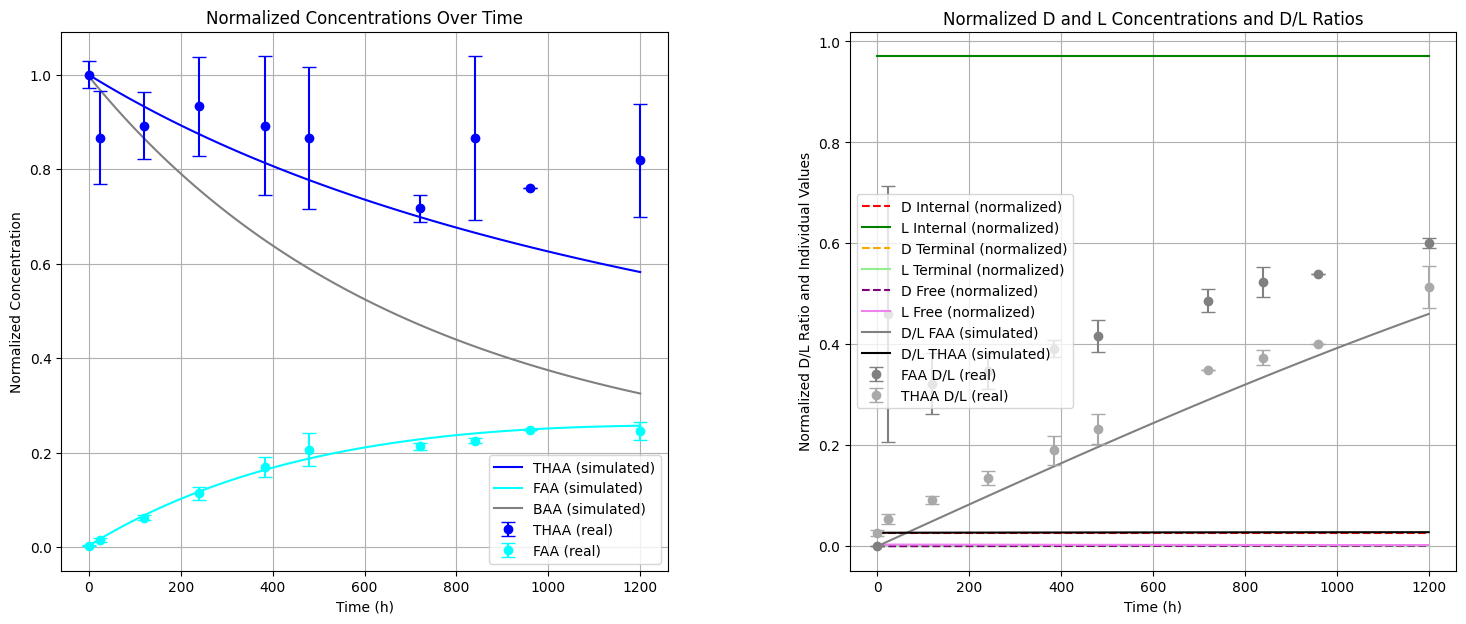

In [67]:
#@title Run Simulation

simulated_data = simulate_amino_acid_hydrolysis(
    real_data,
    amino_acid,
    initial_length,
    fold_water,
    fixed_rate_hydrolysis,
    fixed_rate_loss,
    fixed_rate_internal,
    fixed_rate_terminal,
    fixed_rate_free,
    slow_hydrolysis_pool_size,
    slow_hydrolysis_pool_relative_rate,
    slow_DL_terminal_pool_size,
    slow_DL_terminal_pool_relative_rate,
    slow_DL_internal_pool_size,
    slow_DL_internal_pool_relative_rate
)

# # Print the first few rows of the simulated data to inspect it
# print(simulated_data.head(15))
# print(real_data.head(15))

import matplotlib.pyplot as plt

def plot_simulation_results(simulated_data, real_data, amino_acid):
    """
    Plot concentration metrics and D/L ratios for a given amino acid from simulation and real data,
    including error bars for real data representing standard deviation.

    Args:
        simulated_data (DataFrame): Data generated from the simulation.
        real_data (DataFrame): Real data for comparison, including standard deviation.
        amino_acid (str): Amino acid code used for column naming.
    """
    # Initial THAA concentration for normalization
    initial_thaa = simulated_data['THAA'][0]

    # Define the column names dynamically
    thaa_col = f'{amino_acid}_Conc_THAA_Mean'
    faa_col = f'{amino_acid}_Conc_FAA_Mean'
    thaa_std_col = f'{amino_acid}_Conc_THAA_Std'
    faa_std_col = f'{amino_acid}_Conc_FAA_Std'
    dl_thaa_col = f'{amino_acid}_D/L_THAA_Mean'
    dl_faa_col = f'{amino_acid}_D/L_FAA_Mean'
    dl_thaa_std_col = f'{amino_acid}_D/L_THAA_Std'
    dl_faa_std_col = f'{amino_acid}_D/L_FAA_Std'

    # Set up the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Plot all concentrations on the first subplot with error bars for real data
    axs[0].plot(simulated_data['time (h)'], simulated_data['THAA'] / initial_thaa, label='THAA (simulated)', color='blue')
    axs[0].plot(simulated_data['time (h)'], simulated_data['FAA'] / initial_thaa, label='FAA (simulated)', color='cyan')
    axs[0].plot(simulated_data['time (h)'], simulated_data['BAA'] / initial_thaa, label='BAA (simulated)', color='gray')
    axs[0].errorbar(real_data['time (h)'], real_data[thaa_col] / real_data[thaa_col].iloc[0],
                    yerr=real_data[thaa_std_col] / real_data[thaa_col].iloc[0], fmt='o', color='blue', label='THAA (real)', capsize=5)
    axs[0].errorbar(real_data['time (h)'], real_data[faa_col] / real_data[thaa_col].iloc[0],
                    yerr=real_data[faa_std_col] / real_data[thaa_col].iloc[0], fmt='o', color='cyan', label='FAA (real)', capsize=5)
    axs[0].set_xlabel('Time (h)')
    axs[0].set_ylabel('Normalized Concentration')
    axs[0].set_title('Normalized Concentrations Over Time')
    axs[0].legend()
    axs[0].grid(True)

    # Plot all D/L ratios and individual D and L values on the second subplot with error bars for real data
    axs[1].plot(simulated_data['time (h)'], simulated_data['D_int'] / initial_thaa, label='D Internal (normalized)', linestyle='--', color='red')
    axs[1].plot(simulated_data['time (h)'], simulated_data['L_int'] / initial_thaa, label='L Internal (normalized)', linestyle='-', color='green')
    axs[1].plot(simulated_data['time (h)'], simulated_data['D_term'] / initial_thaa, label='D Terminal (normalized)', linestyle='--', color='orange')
    axs[1].plot(simulated_data['time (h)'], simulated_data['L_term'] / initial_thaa, label='L Terminal (normalized)', linestyle='-', color='lightgreen')
    axs[1].plot(simulated_data['time (h)'], simulated_data['D_free'] / initial_thaa, label='D Free (normalized)', linestyle='--', color='purple')
    axs[1].plot(simulated_data['time (h)'], simulated_data['L_free'] / initial_thaa, label='L Free (normalized)', linestyle='-', color='violet')
    axs[1].plot(simulated_data['time (h)'], simulated_data['D_free'] / simulated_data['L_free'], label='D/L FAA (simulated)', linestyle='-', color='gray')
    axs[1].plot(simulated_data['time (h)'], (simulated_data['D_int'] + simulated_data['D_term'] + simulated_data['D_free'] )/ (simulated_data['L_int'] + simulated_data['L_term'] + simulated_data['L_free']),label='D/L THAA (simulated)', linestyle='-', color='black')
    axs[1].errorbar(real_data['time (h)'], real_data[dl_faa_col], yerr=real_data[dl_faa_std_col], fmt='o', color='grey', label='FAA D/L (real)', capsize=5)
    axs[1].errorbar(real_data['time (h)'], real_data[dl_thaa_col], yerr=real_data[dl_thaa_std_col], fmt='o', color='darkgrey', label='THAA D/L (real)', capsize=5)
    axs[1].set_xlabel('Time (h)')
    axs[1].set_ylabel('Normalized D/L Ratio and Individual Values')
    axs[1].set_title('Normalized D and L Concentrations and D/L Ratios')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

# Example usage:
# Assuming 'simulated_data' and 'real_data' are appropriately prepared and amino_acid is defined
plot_simulation_results(simulated_data, real_data, 'Val')

In [10]:
#print(real_data.head(15))

   Val_Conc_FAA_Mean  Val_Conc_FAA_Std  Val_D/L_FAA_Mean  Val_D/L_FAA_Std  \
13               9.5          3.535534          0.000000         0.000000   
14         43.428571         10.047506          0.460000         0.252982   
15             179.4         14.081903          0.322000         0.060581   
16             328.4         38.952535          0.348000         0.035637   
17             488.5         60.035823          0.391667         0.017224   
18        593.428571         98.098347          0.415714         0.031547   
19        613.333333         21.501938          0.486667         0.023094   
20             647.0         16.522712          0.523333         0.028868   
21             714.0          0.000000          0.540000         0.000000   
22             709.0         55.072679          0.600000         0.010000   

   Val_Conc_THAA_Mean  Val_Conc_THAA_Std  Val_D/L_THAA_Mean  Val_D/L_THAA_Std  \
13        2871.666667          82.136066           0.026667          0.

Streaming output truncated to the last 5000 lines.
         D_int=1151.70, L_int=1710.47
         D_free=4.51, L_free=4.99
         Residual_water=2988.30
Step 70: THAA=353.10, FAA=353.10, BAA=0.00
         D_int=1216.38, L_int=1645.78
         D_free=4.61, L_free=4.89
         Residual_water=2620.20
Step 80: THAA=314.43, FAA=314.43, BAA=0.00
         D_int=1266.09, L_int=1596.08
         D_free=4.66, L_free=4.84
         Residual_water=2333.24
Step 90: THAA=283.43, FAA=283.43, BAA=0.00
         D_int=1304.29, L_int=1557.88
         D_free=4.70, L_free=4.80
         Residual_water=2103.18
Initial values: THAA=2871.6666666666665, FAA=9.5, BAA=2862.1666666666665, D_total=74.5887445887446, L_total=2797.0779220779223
Step 10: THAA=1481.30, FAA=1286.58, BAA=194.73
         D_int=1431.08, L_int=1431.08
         D_free=1.93, L_free=7.57
         Residual_water=12082.16
Step 20: THAA=1007.04, FAA=1007.04, BAA=0.00
         D_int=1431.08, L_int=1431.08
         D_free=3.08, L_free=6.42
        

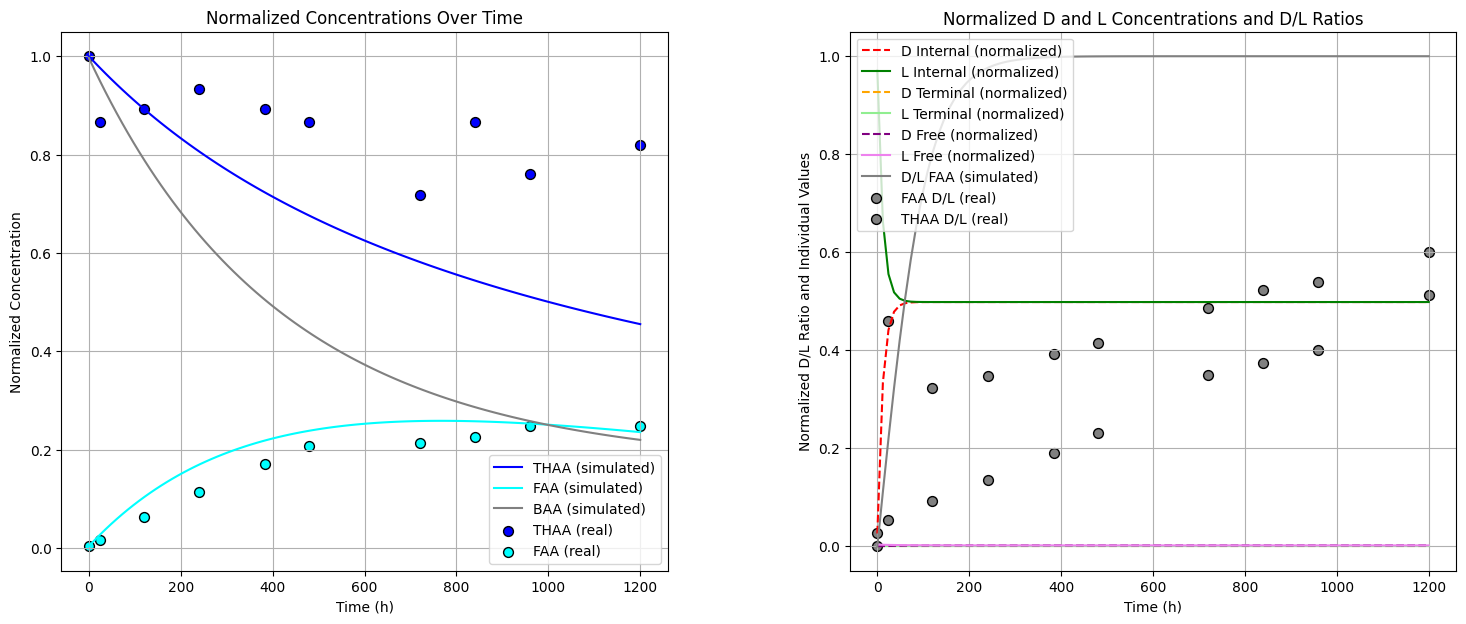

In [17]:
#@title #Optimise


# Define the objective function to optimize
def objective_function(params, real_data, amino_acid):
    # Unpack parameters
    (fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, fold_water,
     slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size,
     slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate) = params

    # Fixed parameters for simulation
    fixed_rate_hydrolysis = 0.02
    fixed_rate_loss = 0.015
    initial_length = 1500

    # Simulate amino acid hydrolysis with these parameters
    simulated_data = simulate_amino_acid_hydrolysis(
        real_data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss,
        fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, slow_hydrolysis_pool_size,
        slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate,
        slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)

    # Assume simulated_data is a dictionary with keys 'D_int', 'L_int', 'D_free', 'L_free', and 'time (h)'
    simulated_THAA_DL = (simulated_data['D_free'] + simulated_data['D_int']) / \
                        (simulated_data['L_free'] + simulated_data['L_int'])
    simulated_FAA_DL = simulated_data['D_free'] / simulated_data['L_free']

    # Compute error between simulated and observed D/L ratios
    observed_THAA_DL = real_data[f'{amino_acid}_D/L_THAA_Mean']
    observed_FAA_DL = real_data[f'{amino_acid}_D/L_FAA_Mean']
    error_THAA_DL = np.sum((simulated_THAA_DL - observed_THAA_DL)**2)
    error_FAA_DL = np.sum((simulated_FAA_DL - observed_FAA_DL)**2)

    return error_THAA_DL + error_FAA_DL

# Define bounds for the optimization parameters
bounds = [
    (0, 1), (0, 1), (0, 1),
    (1, 10), (0, 1), (0, 0.001),
    (0, 1), (0, 0.001), (0, 1), (0, 0.001)
]

# Run optimization
result = differential_evolution(
    objective_function, bounds, args=(real_data, 'Val'),
    strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1.0), recombination=0.7)

# Print optimized parameters
print("Optimized parameters:")
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value}")

print(f"Final optimization error: {result.fun}")


# Create a dictionary to store the optimized parameters
optimized_params = {}

# Store each parameter in the dictionary using descriptive keys
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    optimized_params[name] = value

print(simulated_data.head(15))

print("Optimized parameters stored in dictionary:")
print(optimized_params)

plot_simulation_results(simulated_data, real_data, 'Val')

In [ ]:
# Dummy data
Asx_110_data = {
    'temp (°C)': [110.00] * 10,
    'time (h)': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Asx_Conc_FAA_Mean': [0.03, 0.05, 0.13, 0.19, 0.24, 0.27, 0.25, 0.25, 0.27, 0.25],
    'Asx_Conc_FAA_Std': [0.02, 0.01, 0.01, 0.03, 0.03, 0.05, 0.01, 0.00, 0.00, 0.02],
    'Asx_D/L_FAA_Mean': [0.05, 0.42, 0.62, 0.75, 0.81, 0.84, 0.87, 0.88, 0.89, 0.90],
    'Asx_D/L_FAA_Std': [0.04, 0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.01, 0.00, 0.00],
    'Asx_Conc_THAA_Mean': [1.00, 0.87, 0.88, 0.88, 0.79, 0.74, 0.54, 0.63, 0.53, 0.55],
    'Asx_Conc_THAA_Std': [0.02, 0.10, 0.05, 0.10, 0.13, 0.17, 0.02, 0.12, 0.00, 0.08],
    'Asx_D/L_THAA_Mean': [0.12, 0.41, 0.62, 0.72, 0.78, 0.81, 0.85, 0.86, 0.82, 0.89],
    'Asx_D/L_THAA_Std': [0.00, 0.03, 0.04, 0.01, 0.02, 0.01, 0.00, 0.01, 0.00, 0.01]
}

Val_data = {
    'temp (°C)': [110.00] * 10,
    'time (h)': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Val_Conc_FAA_Mean': [9.50, 43.43, 179.40, 328.40, 488.50, 593.43, 613.33, 647.00, 714.00, 709.00],
    'Val_Conc_FAA_Std': [3.54, 10.05, 14.08, 38.95, 60.04, 98.10, 21.50, 16.52, 0.00, 55.07],
    'Val_D/L_FAA_Mean': [0.00, 0.46, 0.32, 0.35, 0.39, 0.42, 0.49, 0.52, 0.54, 0.60],
    'Val_D/L_FAA_Std': [0.00, 0.25, 0.06, 0.04, 0.02, 0.03, 0.02, 0.03, 0.00, 0.01],
    'Val_Conc_THAA_Mean': [871.67, 2489.43, 2562.17, 2681.50, 2561.43, 2487.80, 2060.33, 2488.33, 2184.00, 2351.00],
    'Val_Conc_THAA_Std': [82.14, 282.91, 205.07, 300.85, 422.25, 433.43, 82.71, 496.51, 0.00, 345.33],
    'Val_D/L_THAA_Mean': [0.03, 0.05, 0.09, 0.14, 0.19, 0.23, 0.35, 0.37, 0.40, 0.51],
    'Val_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.00, 0.02, 0.00, 0.04]
}

Phe_data = {
    'temp (°C)': [110.00] * 10,
    'time (h)': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Phe_Conc_FAA_Mean': [12.00, 45.00, 180.00, 330.00, 490.00, 595.00, 610.00, 650.00, 715.00, 710.00],  # Hypothetical data
    'Phe_Conc_FAA_Std': [3.50, 10.00, 15.00, 40.00, 60.00, 95.00, 20.00, 15.00, 0.00, 55.00],  # Hypothetical data
    'Phe_D/L_FAA_Mean': [0.00, 0.47, 0.33, 0.36, 0.40, 0.43, 0.50, 0.53, 0.55, 0.61],  # Hypothetical data
    'Phe_D/L_FAA_Std': [0.00, 0.20, 0.05, 0.05, 0.02, 0.03, 0.02, 0.03, 0.00, 0.02],  # Hypothetical data
    'Phe_Conc_THAA_Mean': [870.00, 2490.00, 2560.00, 2680.00, 2560.00, 2480.00, 2060.00, 2490.00, 2180.00, 2350.00],  # Hypothetical data
    'Phe_Conc_THAA_Std': [80.00, 280.00, 200.00, 300.00, 420.00, 430.00, 80.00, 490.00, 0.00, 340.00],  # Hypothetical data
    'Phe_D/L_THAA_Mean': [0.02, 0.06, 0.08, 0.13, 0.18, 0.22, 0.34, 0.36, 0.39, 0.50],  # Hypothetical data
    'Phe_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.00, 0.02, 0.00, 0.03]  # Hypothetical data
}
